<a href="https://colab.research.google.com/github/yasharzb/MNIST-Rotate-UNet/blob/main/UNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing libraries
===================

In [13]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as func
import torchvision.datasets as datasets
import torchvision as torchvision
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
import numpy as np
import matplotlib
import random
from matplotlib import pyplot as plt
from torch.nn import MSELoss, CrossEntropyLoss, BCEWithLogitsLoss
import torch.optim as optim
from tqdm import tqdm
import time

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
batch_size = 64
mnist_size = 28
base_transform = transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,),(0.5,)),])

Creating models
===============

At first let's create a custom dataset based on MNIST. The input is the rotated image with a random angle and the output is the original

In [4]:
class SegmentationMNIST(datasets.MNIST):
    def __getitem__(self, index: int):
        inp, tar = super(SegmentationMNIST, self).__getitem__(index)
        angle = random.uniform(-90, 90)
        tar = inp
        inp = transforms.functional.rotate(inp, angle)
        return inp, tar

In [5]:
train_loader = DataLoader(SegmentationMNIST('./data', train=True, download=True, transform=base_transform), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(SegmentationMNIST('./data', train=False, download=True, transform=base_transform), batch_size=batch_size, shuffle=True)

My network is a simpler implementation of UNet which goes like:

<img src='./unet_small.png'>

Which can be considered like this:

<img src='./Unet-self.png'>

In [6]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
    
    def forward(self, x):
        x = self.conv1(x)
        x = func.relu(x)
        x = self.conv2(x)
        x = func.relu(x)
        return x

In [7]:
class Encoder(nn.Module):
    def __init__(self, chs=(1, 32, 64)):
        super().__init__()
        self.enc_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)])
        self.pool       = nn.MaxPool2d(2)
    
    def forward(self, x):
        ftrs = []
        for block in self.enc_blocks:
            x = block(x)
            ftrs.append(x)
            x = self.pool(x)
        return ftrs

In [8]:
class Decoder(nn.Module):
    def __init__(self, chs=(64, 32)):
        super().__init__()
        self.chs         = chs
        self.upconvs    = nn.ModuleList([nn.ConvTranspose2d(chs[i], chs[i+1], 2, 2) for i in range(len(chs)-1)])
        self.dec_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)]) 
        
    def forward(self, x, encoder_features):
        for i in range(len(self.chs)-1):
            x        = self.upconvs[i](x)
            enc_ftrs = self.crop(encoder_features[i], x)
            x        = torch.cat([x, enc_ftrs], dim=1)
            x        = self.dec_blocks[i](x)
        return x
    
    def crop(self, enc_ftrs, x):
        _, _, H, W = x.shape
        enc_ftrs   = torchvision.transforms.CenterCrop([H, W])(enc_ftrs)
        return enc_ftrs

In [9]:
class UNet(nn.Module):
    def __init__(self, out_sz=mnist_size, enc_chs=(1, 32, 64), dec_chs=(64, 32), num_class=1, 
                 retain_dim=False):
        super().__init__()
        self.encoder     = Encoder(enc_chs)
        self.decoder     = Decoder(dec_chs)
        self.head        = nn.Conv2d(dec_chs[-1], num_class, 1)
        self.retain_dim  = retain_dim

    def forward(self, x):
        enc_ftrs = self.encoder(x)
        out      = self.decoder(enc_ftrs[::-1][0], enc_ftrs[::-1][1:])
        out      = self.head(out)
        if self.retain_dim:
            out = F.interpolate(out, out_sz)
        return out

Training Process
================

In [10]:
unet = UNet().to(device)

print(unet)

UNet(
  (encoder): Encoder(
    (enc_blocks): ModuleList(
      (0): Block(
        (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): Block(
        (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Decoder(
    (upconvs): ModuleList(
      (0): ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2))
    )
    (dec_blocks): ModuleList(
      (0): Block(
        (conv1): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
  )
  (head): Conv2d(32, 1, kernel_size=(1, 1), stride=(1, 1))
)


In [14]:
lr = 0.001
loss_func = BCEWithLogitsLoss()
opt = optim.Adam(unet.parameters(), lr)
train_steps = len(train_loader)
test_steps = len(test_loader)
total_loss = {'train': [], 'test': []}
epochs = 10

In [ ]:
print("[INFO] training the network...")
start_time = time.time()
for epoch in range(epochs):
    unet.train()
    
    train_loss = 0
    test_loss = 0
    for i, data in tqdm(enumerate(train_loader), total=train_steps):
        inps, tars = data
        inps, tars = inps.to(device), tars.to(device)
        pred = unet(inps)
        loss = loss_func(pred, tars)
        
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        train_loss += loss
    
    with torch.no_grad():
        unet.eval()
        for inp, tar in test_loader:
            inp, tar = inp.to(device), tar.to(device)
            pred = unet(inp)
            test_loss += loss_func(pred, tar)
    
    avg_train_loss = train_loss / train_steps
    avg_test_loss = test_loss / test_steps
    
    total_loss['train'].append(avg_train_loss.cpu().detach().numpy())
    total_loss['test'].append(avg_test_loss.cpu().detach().numpy())
    print("[INFO] EPOCH: {}/{}".format(epoch + 1, epochs))
    print("Train loss: {:.6f}, Test loss: {:.4f}".format(avg_train_loss, avg_test_loss))

end_time = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(end_time - start_time))

[INFO] training the network...


 44%|████▍     | 411/938 [00:17<00:22, 23.65it/s]

Illustrating the plot and saving the model
==========================================

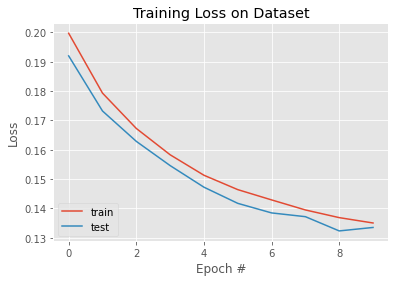

In [18]:
model_path = './model.pth'
plot_path = './plot.png'
tests_path = './test_paths.txt'
plt.style.use("ggplot")
plt.figure()
plt.plot(total_loss["train"], label="train")
plt.plot(total_loss["test"], label="test")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(plot_path)
# serialize the model to disk
torch.save(unet, model_path)